In [1]:
# 数据获取类
import pandas as pd
from pytdx.hq import TdxHq_API
import time as time_module
from datetime import datetime, time, timedelta
import logging

# 配置日志
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TDXDataProvider:
    """
    通达信数据提供器类
    封装所有与通达信数据获取相关的功能
    """
    
    def __init__(self, servers=None):
        """
        初始化数据提供器
        servers: 服务器列表，格式为 [(host, port), ...]
        """
        # 默认服务器列表
        ''' IP和端口：
            ‌上海电信主站‌：180.153.18.170:7709、180.153.18.171:7709。
‌            北京联通主站‌：202.108.253.130:7709、202.108.253.131:7709。
‌            杭州电信主站‌：60.191.117.167:7709、115.238.56.198:7709。
‌            深圳电信主站‌：14.17.75.71:7709。‌
        '''
        self.default_servers = [
            ('180.153.18.170', 7709),
            ('180.153.18.171', 7709),
            ('202.108.253.130', 7709),
            ('202.108.253.131', 7709),
            ('60.191.117.167', 7709),
            ('115.238.56.198', 7709),
            ('14.17.75.71', 7709),
        ]
        
        self.servers = servers or self.default_servers
        self.api = TdxHq_API()
        
        # K线周期映射
        '''
            api.get_security_bars(period, market, stock_code, start, count) 
            参数说明：
            period:  0->5分钟线 1->15分钟线 2->30分钟线 3->1小时 4->日线 5->周线 6->月线 7-> 1分钟线
            start: 从最新的K线开始向历史数据方向的偏移量。0 表示从最新的一根K线开始取。
            count：希望获取的K线根数。请注意，该函数单次请求有最大值限制，通常为 800 条
        '''
        self.period_map = {
            '1min': 7,      # 1分钟
            '5min': 0,      # 5分钟
            '15min': 1,     # 15分钟
            '30min': 2,     # 30分钟
            '1hour': 3,     # 1小时
            'daily': 4,     # 日线
            'weekly': 5,    # 周线
            'monthly': 6,   # 月线
        }
    
    def connect(self):
        """连接到通达信服务器"""
        for host, port in self.servers:
            try:
              #  logger.info(f"尝试连接服务器: {host}:{port}")
                if self.api.connect(host, port):
             #       logger.info("连接成功")
                    return True
            except Exception as e:
             #   logger.warning(f"连接 {host}:{port} 失败: {e}")
                continue
        
        logger.error("所有服务器连接失败")
        return False
    
    def disconnect(self):
        """断开连接"""
        try:
            self.api.disconnect()
      #      logger.info("已断开连接")
        except Exception as e:
            logger.warning(f"断开连接时出错: {e}")
    
    def get_market_code(self, stock_code):
        """根据股票代码返回市场代码"""
        if stock_code.startswith('6'):
            return 1  # 上海
        else:
            return 0  # 深圳
    
    def get_kline_data(self, stock_code, period='daily', count=100):
        """
        获取K线数据
        
        参数:
        stock_code: 股票代码，如 '000001'
        period: K线周期，可选 '1min', '5min', '15min', '30min', '1hour', 'daily', 'weekly', 'monthly'
        count: 获取的K线数量
        
        返回:
        DataFrame: 包含K线数据的DataFrame，列包括: datetime, open, high, low, close, volume, amount
        """
        if not self.connect():
            return None
        
        try:
            market = self.get_market_code(stock_code)
            period_code = self.period_map.get(period, 9)  # 默认为日线
            
            # 获取K线数据
            kline_data = self.api.get_security_bars(period_code, market, stock_code, 0, count)
            
            if kline_data:
                # 转换为DataFrame
                df = self.api.to_df(kline_data)
                
                # 确保datetime列是日期时间类型
                df['datetime'] = pd.to_datetime(df['datetime'])
                
                # 按日期排序
                df = df.sort_values('datetime').reset_index(drop=True)
                
         #       logger.info(f"成功获取 {stock_code} 的 {period} K线数据，共 {len(df)} 条")
                return df
            else:
                logger.warning(f"未获取到 {stock_code} 的K线数据")
                return None
                
        except Exception as e:
            logger.error(f"获取K线数据时出错: {e}")
            return None
        finally:
            self.disconnect()
    
    def get_realtime_quote(self, stock_code):
        """
        获取实时行情数据
        
        返回:
        dict: 包含实时行情数据的字典，包括 price, open, high, low, close, volume 等
        """
        if not self.connect():
            return None
    
        try:
            market = self.get_market_code(stock_code)
            stock_info = self.api.get_security_quotes([(market, stock_code)])
            
            if not stock_info:
                logger.warning(f"未获取到 {stock_code} 的实时行情")
                return None
        
            quote = stock_info[0]
            
            # 处理 OrderedDict
            if isinstance(quote, dict):
                # 已经是字典类型，直接使用
                quote_dict = dict(quote)  # 转换为普通字典
                
                # 重命名一些字段，使其更易读
                field_mapping = {
                    'market': 'market',
                    'code': 'code',
                    'price': 'price',
                    'last_close': 'prev_close',
                    'open': 'open',
                    'high': 'high',
                    'low': 'low',
                    'volume': 'volume',
                    'amount': 'amount',
                    'servertime': 'server_time',
                    'bid1': 'bid1',
                    'ask1': 'ask1',
                    'bid_vol1': 'bid_volume1',
                    'ask_vol1': 'ask_volume1',
                    # 可以继续添加其他需要的字段映射
                }
                
                # 创建新的字典，只保留我们关心的字段
                filtered_dict = {}
                for source_key, target_key in field_mapping.items():
                    if source_key in quote_dict:
                        filtered_dict[target_key] = quote_dict[source_key]
                
       #         logger.info(f"成功获取 {stock_code} 的实时行情: {filtered_dict.get('price', 'N/A')}")
                return filtered_dict
            else:
                logger.warning(f"未知的数据类型: {type(quote)}")
                return None
            
        except Exception as e:
            logger.error(f"获取实时行情时出错: {e}")
            return None
        finally:
            self.disconnect()
    
    def get_realtime_price(self, stock_code):
        """获取实时价格（简化版）"""
        quote = self.get_realtime_quote(stock_code)
        if quote and 'price' in quote:
            return quote['price']
        return None

    def get_detailed_quote(self, stock_code):
        """
        获取详细的行情信息，包括五档行情
        """
        quote_dict = self.get_realtime_quote_fixed(stock_code)
        
        if not quote_dict:
            return None
        
        # 提取五档行情
        bid_ask_data = {}
        for i in range(1, 6):
            bid_key = f'bid{i}'
            ask_key = f'ask{i}'
            bid_vol_key = f'bid_vol{i}'
            ask_vol_key = f'ask_vol{i}'
            
            if bid_key in quote_dict:
                bid_ask_data[f'bid_price_{i}'] = quote_dict[bid_key]
            if ask_key in quote_dict:
                bid_ask_data[f'ask_price_{i}'] = quote_dict[ask_key]
            if bid_vol_key in quote_dict:
                bid_ask_data[f'bid_volume_{i}'] = quote_dict[bid_vol_key]
            if ask_vol_key in quote_dict:
                bid_ask_data[f'ask_volume_{i}'] = quote_dict[ask_vol_key]
        
        # 合并基本信息和五档行情
        detailed_quote = {
            'basic': {
                'code': quote_dict.get('code'),
                'price': quote_dict.get('price'),
                'prev_close': quote_dict.get('prev_close'),
                'open': quote_dict.get('open'),
                'high': quote_dict.get('high'),
                'low': quote_dict.get('low'),
                'volume': quote_dict.get('volume'),
                'amount': quote_dict.get('amount'),
                'server_time': quote_dict.get('server_time')
            },
            'bid_ask': bid_ask_data
        }
        
        return detailed_quote
    
    def get_multiple_realtime_prices(self, stock_codes):
        """
        批量获取多个股票的实时价格
        
        返回:
        dict: {股票代码: 价格}
        """
        if not self.connect():
            return {}
        
        try:
            # 按市场分组股票代码
            sh_codes = [(1, code) for code in stock_codes if code.startswith('6')]
            sz_codes = [(0, code) for code in stock_codes if not code.startswith('6')]
            
            all_codes = sh_codes + sz_codes
            if not all_codes:
                return {}
            
            # 批量获取行情
            stock_info = self.api.get_security_quotes(all_codes)
            
            prices = {}
            for quote in stock_info:
                if  quote and 'price' in quote:
                    prices[quote['code']] = quote['price']
            
            logger.info(f"成功获取 {len(prices)} 只股票的实时价格")
            return prices
            
        except Exception as e:
            logger.error(f"批量获取实时价格时出错: {e}")
            return {}
        finally:
            self.disconnect()
    def get_historical_data_range(self, stock_code, start_date, end_date, period='daily'):
        """
        获取指定日期范围内的历史数据
        
        注意: 这个方法需要先有本地历史数据或使用其他数据源
        这里简化实现，实际应用中可能需要更复杂的数据获取逻辑
        """
        # 这里简化实现，实际应用中可能需要从数据库或其他数据源获取
        # 我们可以通过获取足够多的数据然后过滤来实现
        days_needed = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 100
        df = self.get_kline_data(stock_code, period, count=days_needed)
        
        if df is not None:
            mask = (df['datetime'] >= pd.to_datetime(start_date)) & (df['datetime'] <= pd.to_datetime(end_date))
            filtered_df = df[mask].reset_index(drop=True)
            return filtered_df
        
        return None
    
  

# 使用示例
if __name__ == "__main__":
    # 创建数据提供器实例
    data_provider = TDXDataProvider()
    
    # 测试获取K线数据
    kline_data = data_provider.get_kline_data('000001', period='daily', count=10)
    if kline_data is not None:
        print("K线数据:")
        print(kline_data[['datetime', 'open', 'high', 'low', 'close']].tail())
    
    # 测试获取实时价格
    realtime_price = data_provider.get_realtime_price('000001')
    if realtime_price is not None:
        print(f"\n实时价格: {realtime_price}")
    
    # 测试批量获取
    prices = data_provider.get_multiple_realtime_prices(['000001', '600036'])
    print(f"\n批量价格: {prices}")

K线数据:
             datetime   open   high    low  close
5 2025-11-21 15:00:00  11.80  11.88  11.66  11.69
6 2025-11-24 15:00:00  11.70  11.73  11.60  11.60
7 2025-11-25 15:00:00  11.61  11.80  11.58  11.80
8 2025-11-26 15:00:00  11.81  11.85  11.65  11.69
9 2025-11-27 15:00:00  11.66  11.68  11.58  11.68


2025-11-27 11:44:22,109 - INFO - 成功获取 2 只股票的实时价格



实时价格: 11.68

批量价格: {'600036': 43.31, '000001': 11.68}


In [3]:
class KLineMerger:
    """K线合并器，支持多周期合并和跳空处理"""
    
    def __init__(self, tolerance=0.001):
        self.tolerance = tolerance
        # 不同周期的合并参数
        self.period_params = {
            '1min': {'max_merge_count': 10, 'tolerance_factor': 1.0},
            '5min': {'max_merge_count': 8, 'tolerance_factor': 1.0},
            '15min': {'max_merge_count': 6, 'tolerance_factor': 1.0},
            '30min': {'max_merge_count': 4, 'tolerance_factor': 1.0},
            '1hour': {'max_merge_count': 3, 'tolerance_factor': 1.0},
            'daily': {'max_merge_count': 2, 'tolerance_factor': 1.0},
            'weekly': {'max_merge_count': 1, 'tolerance_factor': 1.0},
            'monthly': {'max_merge_count': 1, 'tolerance_factor': 1.0}
        }
    
    def get_period_params(self, period):
        """获取指定周期的合并参数"""
        return self.period_params.get(period, {'max_merge_count': 2, 'tolerance_factor': 1.0})
    
    def should_merge(self, kline1, kline2, period='daily'):
        """判断两根K线是否应该合并（支持多周期）"""
        params = self.get_period_params(period)
        tolerance = self.tolerance * params['tolerance_factor']
        
        high1, high2 = kline1['high'], kline2['high']
        low1, low2 = kline1['low'], kline2['low']
        
        # 计算最高价差值与基准价格的比率
        high_diff = abs(high2 - high1)
        high_base = max(high1, high2)
        high_ratio = high_diff / high_base if high_base > 0 else 0
        
        # 计算最低价差值与基准价格的比率
        low_diff = abs(low2 - low1)
        low_base = max(low1, low2)
        low_ratio = low_diff / low_base if low_base > 0 else 0
        
        # 检查跳空情况
        close1 = kline1['close']
        open2 = kline2['open']
        has_gap = (open2 > close1 * (1 + tolerance)) or (open2 < close1 * (1 - tolerance))
        
        # 如果存在跳空，不合并
        if has_gap:
            return False
        
        # 只要最高价或最低价差值不超过容差，就合并
        return high_ratio <= tolerance or low_ratio <= tolerance
    
    def merge_klines(self, kline1, kline2, period='daily'):
        """合并两根K线（增强版跳空处理）"""
        params = self.get_period_params(period)
        
        # 取最高点中的最大值作为合并后的最高点
        merged_high = max(kline1['high'], kline2['high'])
        # 取最低点中的最小值作为合并后的最低点
        merged_low = min(kline1['low'], kline2['low'])
        
        # 处理跳空情况
        close1 = kline1['close']
        open2 = kline2['open']
        
        # 如果当日K线的最低点比前一日的收盘价高（向上跳空）
        gap_up = open2 > close1
        if gap_up:
            # 基准线最低点就是前一日的收盘价
            merged_low = min(merged_low, close1)
        
        # 如果当日K线的最高点比前日收盘价低（向下跳空）
        gap_down = open2 < close1
        if gap_down:
            # 基准线最高点就是前一日的收盘价
            merged_high = max(merged_high, close1)
        
        # 开盘价取第一根K线的开盘价
        merged_open = kline1['open']
        # 收盘价取第二根K线的收盘价
        merged_close = kline2['close']
        
        # 成交量合并
        merged_volume = kline1.get('vol', kline1.get('volume', 0)) + kline2.get('vol', kline2.get('volume', 0))
        
        # 日期范围
        if 'datetime' in kline1:
            start_date = kline1['datetime']
            end_date = kline2['datetime']
        elif 'date' in kline1:
            start_date = kline1['date']
            end_date = kline2['date']
        else:
            start_date = kline1.name if hasattr(kline1, 'name') else 'start'
            end_date = kline2.name if hasattr(kline2, 'name') else 'end'
        
        merged_kline = {
            'open': merged_open,
            'high': merged_high,
            'low': merged_low,
            'close': merged_close,
            'volume': merged_volume,
            'start_date': start_date,
            'end_date': end_date,
            'merged': True,
            'merged_count': kline1.get('merged_count', 0) + 1,
            'gap_up': gap_up,
            'gap_down': gap_down,
            'period': period
        }
        
        return merged_kline
    
    def process_data(self, data, period='daily'):
        """处理整个数据集的K线合并（支持多周期）"""
        if len(data) < 2:
            return data
        
        params = self.get_period_params(period)
        max_merge_count = params['max_merge_count']
        
        # 转换为列表形式处理
        if isinstance(data, pd.DataFrame):
            data_list = []
            for i, row in data.iterrows():
                row_dict = row.to_dict()
                if 'datetime' in row_dict:
                    row_dict['date'] = row_dict['datetime']
                elif data.index.name == 'datetime':
                    row_dict['date'] = i
                else:
                    row_dict['date'] = i
                data_list.append(row_dict)
        else:
            data_list = data.copy()
        
        merged_data = []
        i = 0
        
        while i < len(data_list):
            current_kline = data_list[i]
            merged_count = current_kline.get('merged_count', 0)
            
            # 如果已经达到最大合并次数，直接添加
            if merged_count >= max_merge_count:
                current_kline['merged'] = False
                current_kline['gap_up'] = False
                current_kline['gap_down'] = False
                merged_data.append(current_kline)
                i += 1
                continue
            
            # 如果是最后一根K线，直接添加
            if i == len(data_list) - 1:
                current_kline['merged'] = False
                current_kline['merged_count'] = 0
                current_kline['gap_up'] = False
                current_kline['gap_down'] = False
                merged_data.append(current_kline)
                break
            
            next_kline = data_list[i+1]
            
            # 判断是否应该合并
            if self.should_merge(current_kline, next_kline, period):
                # 合并K线
                merged_kline = self.merge_klines(current_kline, next_kline, period)
                merged_data.append(merged_kline)
                i += 2  # 跳过下一根K线
            else:
                # 不合并，直接添加当前K线
                current_kline['merged'] = False
                current_kline['merged_count'] = 0
                current_kline['gap_up'] = False
                current_kline['gap_down'] = False
                merged_data.append(current_kline)
                i += 1
        
        # 转换回DataFrame
        if isinstance(data, pd.DataFrame):
            df = pd.DataFrame(merged_data)
            if 'date' in df.columns:
                df.set_index('date', inplace=True)
            elif 'datetime' in df.columns:
                df.set_index('datetime', inplace=True)
            return df
        
        return merged_data

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, time, timedelta
import logging
from abc import ABC, abstractmethod

# 配置日志
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class BaseStrategy(ABC):
    """
    重构后的策略基类 - 支持多周期K线
    """
    
    def __init__(self, data_provider, capital=100000, name="未命名策略"):
        """
        初始化策略
        
        参数:
        data_provider: 数据提供器实例
        capital: 初始资金
        name: 策略名称
        """
        self.data_provider = data_provider
        self.initial_capital = capital
        self.capital = capital
        self.name = name
        
        # 持仓和交易记录
        self.positions = {}  # {股票代码: 持仓信息}
        self.trade_log = []  # 交易记录列表
        self.performance_log = []  # 绩效记录
        
        # 多周期支持
        self.current_period = 'daily'  # 默认周期
        
        # 添加 last_signals 存储每个股票的最后信号
        self.last_signals = {}

         # 添加详细交易记录（使用回测日期）
        self.detailed_trade_log = []  # 详细交易记录
        
        logger.info(f"初始化策略: {name}, 初始资金: {capital}")
    
    def set_period(self, period):
        """
        设置K线周期
        """
        valid_periods = ['1min', '5min', '15min', '30min', '1hour', 'daily', 'weekly', 'monthly']
        # if period in valid_periods:
        #     self.current_period = period
        #     logger.info(f"策略周期设置为: {period}")
        # else:
        #     logger.warning(f"无效的周期: {period}, 使用默认周期: daily")
    
    @abstractmethod
    def calculate_signals(self, stock_code, data, period=None):
        """
        计算交易信号 - 子类必须实现这个方法
        
        参数:
        stock_code: 股票代码
        data: K线数据
        period: K线周期，如果为None则使用当前周期
        
        返回:
        dict: 包含交易信号的字典
        """
        pass
    
    @abstractmethod
    def should_enter(self, stock_code, signals):
        """
        判断是否应该建仓 - 子类必须实现这个方法
        
        返回:
        bool: 是否建仓
        """
        pass
    
    @abstractmethod
    def should_exit(self, stock_code, signals):
        """
        判断是否应该平仓 - 子类必须实现这个方法
        
        返回:
        bool: 是否平仓
        """
        pass
    
    @abstractmethod
    def should_add_position(self, stock_code, signals):
        """
        判断是否应该加仓 - 子类必须实现这个方法
        
        返回:
        bool: 是否加仓
        """
        pass
    
    def get_position_size(self, price, risk_per_trade=0.02):
        """
        计算仓位大小
        
        参数:
        price: 股票价格
        risk_per_trade: 每笔交易风险比例
        
        返回:
        int: 股票数量
        """
        risk_amount = self.capital * risk_per_trade
        shares = int(risk_amount / price)
        return max(1, shares)  # 至少1股
    
    def enter_position(self, stock_code, price, shares, reason="建仓", trade_date=None):
        """
        建立仓位
        
        返回:
        bool: 是否成功建仓
        """
        cost = price * shares
        
        if cost > self.capital:
            logger.warning(f"资金不足，无法建仓 {stock_code}")
            return False
        # 使用回测日期，如果没有提供则使用当前时间
        current_time = trade_date if trade_date else datetime.now()
        
        # 记录持仓
        self.positions[stock_code] = {
            'entry_price': price,
            'shares': shares,
            'entry_date': datetime.now(),
            'entry_reason': reason,
            'period': self.current_period  # 记录建仓时的周期
        }
        
        # 更新资金
        self.capital -= cost
        
        # 记录交易
        trade_record = {
            'date': current_time,
            'stock': stock_code,
            'action': 'BUY',
            'price': price,
            'shares': shares,
            'value': cost,
            'reason': reason,
            'capital': self.capital,
            'period': self.current_period
        }
        self.trade_log.append(trade_record)
        
        # 添加详细记录
        detailed_record = {
            'timestamp': current_time,
            'stock': stock_code,
            'type': '建仓',
            'price': price,
            'shares': shares,
            'value': cost,
            'reason': reason,
            'remaining_capital': self.capital,
            'period': self.current_period
        }
        self.detailed_trade_log.append(detailed_record)
        
        time_str = current_time.strftime('%Y-%m-%d %H:%M:%S') if hasattr(current_time, 'strftime') else str(current_time)
        logger.info(f"{time_str} {reason} {stock_code}: {shares}股 @ {price:.2f}, 成本: {cost:.2f}, 周期: {self.current_period}")
        return True
    
    def exit_position(self, stock_code, price, reason="平仓", trade_date=None):
        """
        平仓
        
        返回:
        bool: 是否成功平仓
        """
        if stock_code not in self.positions:
            logger.warning(f"尝试平仓但未持有 {stock_code}")
            return False
        
        position = self.positions[stock_code]
        shares = position['shares']
        exit_value = shares * price
        entry_cost = position['entry_price'] * shares
        
        # 计算盈亏
        pnl = exit_value - entry_cost
        pnl_percent = (pnl / entry_cost) * 100
        
        # 更新资金
        self.capital += exit_value

        # 使用回测日期，如果没有提供则使用当前时间
        current_time = trade_date if trade_date else datetime.now()
        
        # 记录交易
        trade_record = {
            'date': current_time,
            'stock': stock_code,
            'action': 'SELL',
            'price': price,
            'shares': shares,
            'value': exit_value,
            'pnl': pnl,
            'pnl_percent': pnl_percent,
            'reason': reason,
            'capital': self.capital,
            'period': self.current_period
        }
        self.trade_log.append(trade_record)

         # 添加详细记录
        detailed_record = {
            'timestamp': current_time,
            'stock': stock_code,
            'type': '止损' if reason == '止损' else '平仓',
            'price': price,
            'shares': shares,
            'value': exit_value,
            'pnl': pnl,
            'pnl_percent': pnl_percent,
            'reason': reason,
            'remaining_capital': self.capital,
            'period': self.current_period
        }
        self.detailed_trade_log.append(detailed_record)
        
        # 移除持仓
        del self.positions[stock_code]
        
        action_type = "盈利" if pnl > 0 else "亏损"
        time_str = current_time.strftime('%Y-%m-%d %H:%M:%S') if hasattr(current_time, 'strftime') else str(current_time)
        logger.info(f"{time_str} {reason} {stock_code}: {shares}股 @ {price:.2f}, "
                   f"{action_type}: {pnl:.2f}({pnl_percent:.2f}%), 周期: {self.current_period}")
        
        return True
    
    def add_to_position(self, stock_code, price, shares, reason="加仓", trade_date=None):
        """
        加仓
        
        返回:
        bool: 是否成功加仓
        """
        if stock_code not in self.positions:
            logger.warning(f"尝试加仓但未持有 {stock_code}")
            return False
        
        cost = price * shares
        
        if cost > self.capital:
            logger.warning(f"资金不足，无法加仓 {stock_code}")
            return False
        
        # 更新持仓（计算平均成本）
        position = self.positions[stock_code]
        total_shares = position['shares'] + shares
        total_cost = (position['entry_price'] * position['shares']) + cost
        new_avg_price = total_cost / total_shares
        
        position['shares'] = total_shares
        position['entry_price'] = new_avg_price
        position['add_position_date'] = datetime.now()
        
        # 更新资金
        self.capital -= cost

        # 使用回测日期，如果没有提供则使用当前时间
        current_time = trade_date if trade_date else datetime.now()
        
        # 记录交易
        trade_record = {
            'date': current_time,
            'stock': stock_code,
            'action': 'ADD',
            'price': price,
            'shares': shares,
            'value': cost,
            'reason': reason,
            'capital': self.capital,
            'period': self.current_period
        }
        self.trade_log.append(trade_record)
        
        # 添加详细记录
        detailed_record = {
            'timestamp': current_time,
            'stock': stock_code,
            'type': '加仓',
            'price': price,
            'shares': shares,
            'value': cost,
            'reason': reason,
            'remaining_capital': self.capital,
            'period': self.current_period,
            'new_avg_price': new_avg_price
        }
        self.detailed_trade_log.append(detailed_record)
        
        time_str = current_time.strftime('%Y-%m-%d %H:%M:%S') if hasattr(current_time, 'strftime') else str(current_time)
        logger.info(f"{time_str} {reason} {stock_code}: {shares}股 @ {price:.2f}, 平均成本: {new_avg_price:.2f}, 周期: {self.current_period}")
        return True
    
    def run_on_stock(self, stock_code, data=None, period=None, count=10):
        """
        在单个股票上运行策略
        
        返回:
        bool: 是否有交易发生
        """
        # 设置周期
        if period:
            self.set_period(period)
        
        # 获取数据（如果未提供）
        if data is None:
            data = self.data_provider.get_kline_data(stock_code, self.current_period, count)
        
        if data is None or len(data) < 3:
            logger.warning(f"数据不足，无法分析 {stock_code}, 周期: {self.current_period}")
            return False
        
        # 计算信号
        signals = self.calculate_signals(stock_code, data, self.current_period)

         # 保存信号到 last_signals
        self.last_signals[stock_code] = signals

         # 获取当前日期
        current_date = None
        if hasattr(data, 'index') and hasattr(data.index, 'dtype'):
            # 如果索引是日期时间类型
            if pd.api.types.is_datetime64_any_dtype(data.index):
                current_date = data.index[-1]
            else:
                # 尝试从数据中获取日期
                if 'datetime' in data.columns:
                    current_date = data.iloc[-1]['datetime']
                else:
                    # 如果都没有，使用当前时间
                    current_date = datetime.now()
        
        
        # 检查是否需要平仓
        if stock_code in self.positions and self.should_exit(stock_code, signals):
            current_price = signals.get('current_price', data.iloc[-1]['close'])
            self.exit_position(stock_code, current_price, signals.get('exit_reason', '策略平仓'),current_date)
            return True
        
        # 检查是否需要加仓
        if stock_code in self.positions and self.should_add_position(stock_code, signals):
            current_price = signals.get('current_price', data.iloc[-1]['close'])
            add_shares = self.get_position_size(current_price, 0.01)  # 加仓使用较小风险比例
            self.add_to_position(stock_code, current_price, add_shares, signals.get('add_reason', '策略加仓'),current_date)
            return True
        
        # 检查是否需要建仓
        if stock_code not in self.positions and self.should_enter(stock_code, signals):
            current_price = signals.get('current_price', data.iloc[-1]['close'])
            shares = self.get_position_size(current_price)
            self.enter_position(stock_code, current_price, shares, signals.get('enter_reason', '策略建仓'),current_date)
            return True
        
        return False
    
    def run_on_multiple_stocks(self, stock_codes, period=None, count=10):
        """
        在多个股票上运行策略
        """
        if period:
            self.set_period(period)
            
        trades_count = 0
        for stock_code in stock_codes:
            if self.run_on_stock(stock_code, period=self.current_period, count=count):
                trades_count += 1
        
        logger.info(f"在 {len(stock_codes)} 只股票上运行策略，周期: {self.current_period}, 发生 {trades_count} 笔交易")
        return trades_count
    
    def get_portfolio_value(self, current_prices=None):
        """
        计算投资组合当前价值
        """
        # 获取当前价格
        if current_prices is None and self.positions:
            stock_codes = list(self.positions.keys())
            current_prices = self.data_provider.get_multiple_realtime_prices(stock_codes)
        
        portfolio_value = self.capital
        
        for stock_code, position in self.positions.items():
            if current_prices and stock_code in current_prices:
                current_price = current_prices[stock_code]
            else:
                # 如果没有实时价格，使用持仓成本
                current_price = position['entry_price']
            
            position_value = position['shares'] * current_price
            portfolio_value += position_value
        
        return portfolio_value
    
    def get_performance_summary(self):
        """
        获取策略绩效摘要
        """
        current_value = self.get_portfolio_value()
        total_return = (current_value - self.initial_capital) / self.initial_capital * 100
        
        # 计算胜率
        if self.trade_log:
            exit_trades = [t for t in self.trade_log if t['action'] == 'SELL']
            if exit_trades:
                winning_trades = [t for t in exit_trades if t.get('pnl', 0) > 0]
                win_rate = len(winning_trades) / len(exit_trades) * 100
            else:
                win_rate = 0
        else:
            win_rate = 0
        
        summary = {
            '策略名称': self.name,
            '当前周期': self.current_period,
            '初始资金': self.initial_capital,
            '当前价值': current_value,
            '总收益率(%)': round(total_return, 2),
            '持仓数量': len(self.positions),
            '交易次数': len(self.trade_log),
            '胜率(%)': round(win_rate, 2) if win_rate else 0,
            '当前资金': self.capital
        }
        
        return summary
    def get_detailed_trade_summary(self):
        """获取详细交易摘要"""
        if not self.detailed_trade_log:
            return "暂无交易记录"
        
        summary = f"\n=== {self.name} 详细交易记录 ===\n"
        
        for i, trade in enumerate(self.detailed_trade_log[-10:], 1):  # 显示最近10条记录
            time_str = trade['timestamp'].strftime('%Y-%m-%d %H:%M:%S') if hasattr(trade['timestamp'], 'strftime') else str(trade['timestamp'])
            if trade['type'] in ['建仓', '加仓']:
                summary += f"{i}. {time_str} {trade['type']} {trade['stock']} "
                summary += f"{trade['shares']}股 @ {trade['price']:.2f}, 金额: {trade['value']:.2f}\n"
                if 'new_avg_price' in trade:
                    summary += f"   新平均成本: {trade['new_avg_price']:.2f}\n"
            else:
                pnl_info = f", 盈亏: {trade['pnl']:.2f}({trade['pnl_percent']:.2f}%)" if 'pnl' in trade else ""
                summary += f"{i}. {time_str} {trade['type']} {trade['stock']} "
                summary += f"{trade['shares']}股 @ {trade['price']:.2f}{pnl_info}\n"
            summary += f"   原因: {trade['reason']}, 剩余资金: {trade['remaining_capital']:.2f}\n"
        
        return summary
    
    def print_detailed_summary(self):
        """打印详细摘要"""
        print(self.get_detailed_trade_summary())
        
    def print_summary(self):
        """打印策略摘要"""
        summary = self.get_performance_summary()
        
        print(f"\n=== {summary['策略名称']} 策略摘要 ===")
        for key, value in summary.items():
            print(f"{key}: {value}")
        
        if self.positions:
            print("\n当前持仓:")
            for stock_code, position in self.positions.items():
                print(f"  {stock_code}: {position['shares']}股 @ {position['entry_price']:.2f}")
        
        if self.trade_log:
            print(f"\n最近5笔交易:")
            for trade in self.trade_log[-5:]:
                action = f"{trade['action']} {trade['stock']}"
                pnl_info = f", 盈亏: {trade.get('pnl', 0):.2f}" if 'pnl' in trade else ""
                print(f"  {trade['date'].strftime('%Y-%m-%d %H:%M')} {action} "
                      f"{trade['shares']}股 @ {trade['price']:.2f}{pnl_info}, 周期: {trade.get('period', 'N/A')}")


In [5]:
class BreakoutStrategy(BaseStrategy):
    """
    基于BaseStrategy的突破策略实现（修正版）
    建仓条件在收盘前5分钟判断当日最高价是否未超过前一日最高价
    """
    
    def __init__(self, data_provider, capital=100000, name="突破策略-尾盘判断", 
                 tolerance=0, max_additions=5, add_position_ratio=0.5,
                 close_time_judgment=True, judgment_time="14:55:00", enable_kline_merge=True):
        """
        初始化突破策略
        """
        super().__init__(data_provider, capital, name)
        
        self.tolerance = tolerance
        self.max_additions = max_additions
        self.add_position_ratio = add_position_ratio
        self.close_time_judgment = close_time_judgment
        self.judgment_time = judgment_time
        self.enable_kline_merge = enable_kline_merge

        # K线合并器
        self.kline_merger = KLineMerger(tolerance)
        
        # 策略特定状态
        self.benchmark_high = None
        self.addition_count = 0
        self.today_high = None
        self.today_low = None
        self.entry_day0_low = None
        self.entry_day0_high = None
        self.entry_date = None

        # 添加last_signals存储
      #  self.last_signals = {}
        self.merged_data = {}
        
        logger.info(f"初始化突破策略: 容差={tolerance*100}%, 最大加仓={max_additions}次, 尾盘判断={close_time_judgment}")

    def reset_daily_data(self):
        """重置每日数据"""
        self.today_high = None
        self.today_low = None

    def preprocess_data(self, stock_code, data, period):
        """预处理数据：应用K线合并"""
        if not self.enable_kline_merge:
            if isinstance(data, pd.DataFrame):
                data_copy = data.copy()
                data_copy['merged'] = False
                data_copy['merged_count'] = 0
                data_copy['gap_up'] = False
                data_copy['gap_down'] = False
                return data_copy
            else:
                for item in data:
                    item['merged'] = False
                    item['merged_count'] = 0
                    item['gap_up'] = False
                    item['gap_down'] = False
                return data
        
        if stock_code in self.merged_data:
            return self.merged_data[stock_code]
        
        # 处理K线合并
        processed_data = self.kline_merger.process_data(data, period)
        
        if processed_data is not None and len(processed_data) > 0:
            if not isinstance(processed_data, pd.DataFrame):
                df = pd.DataFrame(processed_data)
                if 'date' in df.columns:
                    df.set_index('date', inplace=True)
                elif 'start_date' in df.columns:
                    df.set_index('start_date', inplace=True)
            else:
                df = processed_data
            
            self.merged_data[stock_code] = df
            return df
        
        return data
    
    def calculate_signals(self, stock_code, data, period=None):
        """
        计算突破策略的信号（修正版：支持尾盘判断）
        """
        if period is None:
            period = self.current_period
            
        # 预处理数据：应用K线合并
        processed_data = self.preprocess_data(stock_code, data, period)
        
        if len(data) < 2:
            return {}

        # 重置每日数据（新的一天开始）
        self.reset_daily_data()
        
        # 检查当前K线是否是合并的K线
        current_kline_merged = processed_data.iloc[-1].get('merged', False)
        current_kline_merged_count = processed_data.iloc[-1].get('merged_count', 0)
        
        # 获取当前时间（如果是实时数据）
        current_time = datetime.now().time() if hasattr(data, 'real_time') else None
        
        # 提取关键价格（使用合并后的数据）
        day0_high = processed_data.iloc[-2]['high'] if len(processed_data) >= 2 else processed_data.iloc[-1]['high']
        day0_low = processed_data.iloc[-2]['low'] if len(processed_data) >= 2 else processed_data.iloc[-1]['low']
        day0_close = processed_data.iloc[-2]['close'] if len(processed_data) >= 2 else processed_data.iloc[-1]['close']
        
        day1_high = processed_data.iloc[-1]['high']
        day1_low = processed_data.iloc[-1]['low']
        day1_close = processed_data.iloc[-1]['close']
        day1_open = processed_data.iloc[-1]['open']
        
        # 处理跳空情况
        if day1_open > day0_close:
            adjusted_day0_low = min(day0_low, day0_close)
            day0_low = adjusted_day0_low
        
        if day1_open < day0_close:
            adjusted_day0_high = max(day0_high, day0_close)
            day0_high = adjusted_day0_high
        
        # 获取实时价格
        current_price = self.data_provider.get_realtime_price(stock_code) or day1_close

        # 检查是否在持仓中
        in_position = stock_code in self.positions
        
        # 更新当日最高最低价（用于尾盘判断）
        if current_price is not None:
            if self.today_high is None or current_price > self.today_high:
                self.today_high = current_price
            if self.today_low is None or current_price < self.today_low:
                self.today_low = current_price
        
        # 判断是否在收盘前5分钟
        is_close_time = False
        if current_time and self.close_time_judgment:
            judgment_time_obj = datetime.strptime(self.judgment_time, "%H:%M:%S").time()
            close_time = datetime.strptime("15:00:00", "%H:%M:%S").time()
            is_close_time = (current_time >= judgment_time_obj and current_time < close_time)
        
        # 计算建仓条件
        judgment_high = self.today_high if (is_close_time and self.today_high is not None) else day1_high
        judgment_low = self.today_low if (is_close_time and self.today_low is not None) else day1_low
        
        # 修改：建仓条件不考虑误差
        entry_condition1 = judgment_low > day0_low
        entry_condition2 = judgment_high <= day0_high
        
        # 只有在收盘前5分钟或非尾盘判断模式下才允许建仓
        entry_condition_time = not self.close_time_judgment or is_close_time

        # 修改：合并的K线当日不做买入判断
        if current_kline_merged:
            entry_condition1 = False
            entry_condition2 = False
            logger.info(f"跳过建仓判断: {stock_code} 当前K线为合并K线 (合并了{current_kline_merged_count}根K线)")

        # 计算加仓条件
        if in_position:
            position_info = self.positions[stock_code]
            current_benchmark_high = position_info.get('benchmark_high', 0)
            
            # 修改：加仓条件不考虑误差
            add_condition = judgment_high > current_benchmark_high
            add_condition_time = not self.close_time_judgment or is_close_time
        else:
            add_condition = False
            add_condition_time = False
        
        # 计算止损条件
        if in_position:
            position_info = self.positions[stock_code]
            entry_day0_low = position_info.get('entry_day0_low', day0_low)
            stop_condition = judgment_low < entry_day0_low
        else:
            stop_condition = False
                
        # 构建信号字典
        signals = {
            'day0_high': day0_high,
            'day0_low': day0_low,
            'day1_high': day1_high,
            'day1_low': day1_low,
            'day1_close': day1_close,
            'judgment_high': judgment_high,
            'judgment_low': judgment_low,
            'current_price': current_price,
            'entry_condition1': entry_condition1,
            'entry_condition2': entry_condition2,
            'entry_condition_time': entry_condition_time,
            'add_condition': add_condition,
            'add_condition_time': add_condition_time,
            'stop_condition': stop_condition,
            'in_position': in_position,
            'addition_count': self.addition_count if in_position else 0,
            'is_close_time': is_close_time,
            'today_high': self.today_high,
            'today_low': self.today_low,
            'entry_day0_low': self.entry_day0_low if in_position else day0_low,
            'current_benchmark_high': self.benchmark_high if in_position else 0,
            'kline_merged': current_kline_merged,
            'merged_count': current_kline_merged_count,
            'gap_up': day1_open > day0_close,
            'gap_down': day1_open < day0_close,
            'period': period
        }
        
        # 保存信号到last_signals
        self.last_signals[stock_code] = signals
        
        return signals
    
    def should_enter(self, stock_code, signals):
        """判断是否应该建仓"""
        if signals.get('kline_merged', False):
            logger.info(f"跳过建仓: {stock_code} 当前为合并K线")
            return False
        
        entry_signal = (signals.get('entry_condition1', False) and 
                signals.get('entry_condition2', False) and 
                signals.get('entry_condition_time', False) and 
                not signals.get('in_position', False))
        
        if entry_signal:
            logger.info(f"建仓信号触发: {stock_code}")
            
        return entry_signal
    
    def should_exit(self, stock_code, signals):
        """判断是否应该平仓"""
        stop_signal = signals.get('stop_condition', False) and signals.get('in_position', False)

        if stop_signal:
            logger.info(f"止损信号触发: {stock_code}")
        
        return stop_signal
    
    def should_add_position(self, stock_code, signals):
        """判断是否应该加仓"""
        in_position = signals.get('in_position', False)
        add_condition = signals.get('add_condition', False)
        add_condition_time = signals.get('add_condition_time', False)
        addition_count = signals.get('addition_count', 0)

        add_signal = (in_position and add_condition and add_condition_time and 
                addition_count < self.max_additions)
        
        if add_signal:
            logger.info(f"加仓信号触发: {stock_code}, 加仓次数={addition_count + 1}")
        
        return add_signal
    
    def get_position_size(self, price, risk_per_trade=0.02):
        """计算仓位大小"""
        position_value = self.capital * 0.2
        shares = int(position_value / price)
        return max(1, shares)
    
    def enter_position(self, stock_code, price, shares, reason="建仓"):
        """建立仓位"""
        signals = self.last_signals.get(stock_code, {})
        
        close_price = signals.get('day1_close', price)
        slippage = close_price * self.tolerance
        adjusted_price = close_price + slippage

         # 获取日期信息
        trade_date = signals.get('current_date')
        
        success = super().enter_position(stock_code, adjusted_price, shares, reason, trade_date )
        
        if success:
            self.benchmark_high = signals.get('day0_high', adjusted_price)
            self.entry_day0_low = signals.get('day0_low', adjusted_price)
            self.entry_day0_high = signals.get('day0_high', adjusted_price)
            self.addition_count = 0
            
            self.today_high = None
            self.today_low = None
            
            if stock_code in self.positions:
                self.positions[stock_code]['benchmark_high'] = self.benchmark_high
                self.positions[stock_code]['entry_day0_low'] = self.entry_day0_low
                self.positions[stock_code]['addition_count'] = self.addition_count
                self.positions[stock_code]['entry_day0_low'] = self.entry_day0_low

             # 记录建仓详细信息
            date_str = trade_date.strftime('%Y-%m-%d') if hasattr(trade_date, 'strftime') else str(trade_date)
            logger.info(f"建仓成功: {stock_code}, "
                       f"日期={date_str}, "
                       f"基准最高价={self.benchmark_high:.2f}, "
                       f"建仓价格={adjusted_price:.2f}, "
                       f"止损价={self.entry_day0_low:.2f}")
                
            
        
        return success
    
    def add_to_position(self, stock_code, price, shares, reason="加仓"):
        """加仓"""
        signals = self.last_signals.get(stock_code, {})
        
        close_price = signals.get('day1_close', price)
        
        if stock_code in self.positions:
            current_shares = self.positions[stock_code]['shares']
            add_shares = int(current_shares * self.add_position_ratio)
            add_shares = max(1, add_shares)
        else:
            add_shares = shares

        # 获取日期信息
        trade_date = signals.get('current_date')
        
        success = super().add_to_position(stock_code, close_price, add_shares, reason,trade_date)
        
        if success:
            self.addition_count += 1
            
            self.today_high = None
            self.today_low = None
            
            if stock_code in self.positions:
                self.positions[stock_code]['benchmark_high'] = self.benchmark_high
                self.positions[stock_code]['addition_count'] = self.addition_count

             # 记录加仓详细信息
            date_str = trade_date.strftime('%Y-%m-%d') if hasattr(trade_date, 'strftime') else str(trade_date)
            logger.info(f"加仓成功: {stock_code}, "
                       f"日期={date_str}, "
                       f"第{self.addition_count}次加仓, "
                       f"基准最高价={self.benchmark_high:.2f}")
        
        return success
    
    def exit_position(self, stock_code, price, reason="平仓"):
        """平仓"""
        signals = self.last_signals.get(stock_code, {})
        
        close_price = signals.get('day1_close', price)

        # 获取日期信息
        trade_date = signals.get('current_date')
        
        success = super().exit_position(stock_code, price, reason)
        
        if success:
            self.benchmark_high = None
            self.entry_day0_low = None
            self.entry_day0_high = None
            self.addition_count = 0
            self.today_high = None
            self.reset_daily_data()

            if stock_code in self.last_signals:
                del self.last_signals[stock_code]
            
             # 记录平仓详细信息
            date_str = trade_date.strftime('%Y-%m-%d') if hasattr(trade_date, 'strftime') else str(trade_date)
            logger.info(f"平仓成功: {stock_code}, "
                       f"日期={date_str}, "
                       f"原因={reason}, "
                       f"平仓价格={close_price:.2f}")
        
        return success

In [6]:
class BottomPatternStrategy(BaseStrategy):
    """底分型策略 - 修复建仓条件和价格问题"""
    
    def __init__(self, data_provider, capital=100000, name="底分型策略"):
        super().__init__(data_provider, capital, name)
        
        # 策略状态
        self.a_line_high = None
        self.a_line_low = None
        self.a_line_date = None
        self.has_bought = False
        
        # 建仓时的A点信息（用于止损）
        self.entry_a_line_high = None  # 建仓时的A线最高点
        self.entry_a_line_low = None   # 建仓时的A线最低点（止损点）
        self.entry_a_line_date = None  # 建仓时的A线日期
        
     
        
        # A点记录（底分型策略特有）
        self.a_point_log = []
        
        logger.info(f"初始化底分型策略: {name}")
    
    def calculate_signals(self, stock_code, data, period=None):
        """计算底分型策略信号"""
        if len(data) < 2:
            return {}
        
        # 获取价格数据
        current_high = data.iloc[-1]['high']
        current_low = data.iloc[-1]['low']
        current_close = data.iloc[-1]['close']
        prev_low = data.iloc[-2]['low']
        prev_high = data.iloc[-2]['high']
        
        # 获取日期信息
        current_date = None
        if hasattr(data, 'index') and hasattr(data.index, 'dtype'):
            if pd.api.types.is_datetime64_any_dtype(data.index):
                current_date = data.index[-1]
            else:
                if 'datetime' in data.columns:
                    current_date = data.iloc[-1]['datetime']
                else:
                    current_date = datetime.now()
        else:
            current_date = datetime.now()
        
        # 获取实时价格
        current_price = self.data_provider.get_realtime_price(stock_code) or current_close
        
        # 如果已经建仓，只检查止损
        if self.has_bought:
            # 止损信号：买入后跌破建仓时的A线最低价
            stop_signal = (self.entry_a_line_low is not None and 
                          current_low < self.entry_a_line_low)

             # 即使在持仓状态下，也要检查是否形成新的A点（为后续交易做准备）
            a_line_condition = current_low < prev_low

             # 如果满足A线条件，更新A线信息（即使持仓中也要更新）
            if a_line_condition:
                self.a_line_high = current_high
                self.a_line_low = current_low
                self.a_line_date = current_date
                
                # 记录A点
                self.log_a_point(stock_code, current_high, current_low, current_date, "持仓中发现新的A点")
            
            signals = {
                'stop_signal': stop_signal,
                'current_price': current_price,
                'current_high': current_high,
                'current_low': current_low,
                'current_close': current_close,  # 添加收盘价
                'in_position': stock_code in self.positions,
                'has_bought': self.has_bought,
                'period': period,
                'current_date': current_date,
                'entry_a_line_low': self.entry_a_line_low,
                'prev_low': prev_low,
                'prev_high': prev_high
            }
            return signals
        
         # 如果未建仓，寻找A点和买入机会
        # 正常寻找A点
        a_line_condition = current_low < prev_low
        
        # 如果满足A线条件，更新A点信息
        if a_line_condition:
                self.a_line_high = current_high
                self.a_line_low = current_low
                self.a_line_date = current_date
                
                # 记录A点
                self.log_a_point(stock_code, current_high, current_low, current_date, "找到新的A点")
        
        # 买入信号：突破A线最高价且未买入过，且A点在止损之后
        buy_signal = (self.a_line_high is not None and 
                     current_high > self.a_line_high and 
                     not self.has_bought )
        
        # 构建信号字典
        signals = {
            'a_line_condition': a_line_condition,
            'a_line_high': self.a_line_high,
            'a_line_low': self.a_line_low,
            'a_line_date': self.a_line_date,
            'buy_signal': buy_signal,
            'stop_signal': False,  # 未建仓时没有止损信号
            'current_price': current_price,
            'current_high': current_high,
            'current_low': current_low,
            'current_close': current_close,  # 添加收盘价
            'in_position': stock_code in self.positions,
            'has_bought': self.has_bought,
            'period': period,
            'current_date': current_date,
            'prev_low': prev_low,
            'prev_high': prev_high
        }
        
        return signals
    
    def should_enter(self, stock_code, signals):
        """判断是否应该建仓"""
        # # 检查是否有有效的A点
        # if self.a_line_high is None or self.a_line_low is None:
        #     return False
            
        # # 检查A点是否在止损之后
        # if self.last_stop_date is not None and self.a_line_date <= self.last_stop_date:
        #     return False
            
        return signals.get('buy_signal', False) and not signals.get('in_position', False)
    
    def should_exit(self, stock_code, signals):
        """判断是否应该平仓（止损）"""
        # 只有在已建仓状态下才检查止损
        if not signals.get('has_bought', False):
            return False
            
        return signals.get('stop_signal', False) and stock_code in self.positions
    
    def should_add_position(self, stock_code, signals):
        """底分型策略不加仓"""
        return False
    
    def enter_position(self, stock_code, price, shares, reason="买入", trade_date=None):
        """建立仓位 - 使用建仓日收盘价"""
        # 获取信号中的日期信息
        signals = self.last_signals.get(stock_code, {})
        
        # 如果 trade_date 没有提供，从信号中获取
        if trade_date is None:
            trade_date = signals.get('current_date')
        
        # 使用建仓日收盘价作为建仓价格
        close_price = signals.get('current_close', price)
        
        success = super().enter_position(stock_code, close_price, shares, reason, trade_date)
        
        if success:
            self.has_bought = True
            
            # 保存建仓时的A点信息（用于止损）
            self.entry_a_line_high = self.a_line_high
            self.entry_a_line_low = self.a_line_low
            self.entry_a_line_date = self.a_line_date
            
            # 格式化A点日期显示
            if hasattr(self.entry_a_line_date, 'strftime'):
                a_line_date_str = self.entry_a_line_date.strftime('%Y-%m-%d %H:%M:%S')
            else:
                a_line_date_str = str(self.entry_a_line_date)
            
            logger.info(f"底分型买入成功: {stock_code}, "
                       f"建仓价格={close_price:.2f} (收盘价), "
                       f"A线最高={self.entry_a_line_high:.2f}, "
                       f"A线最低={self.entry_a_line_low:.2f} (止损点), "
                       f"A点日期={a_line_date_str}")
        
        return success
    
    def exit_position(self, stock_code, price, reason="止损", trade_date=None):
        """平仓 - 使用止损日收盘价"""
        # 获取信号中的日期信息
        signals = self.last_signals.get(stock_code, {})
        
        # 如果 trade_date 没有提供，从信号中获取
        if trade_date is None:
            trade_date = signals.get('current_date')
        
        # 使用止损日收盘价作为平仓价格
        close_price = signals.get('current_close', price)
        
        success = super().exit_position(stock_code, close_price, reason, trade_date)
        
        if success:
            # 记录止损信息
            logger.info(f"底分型止损成功: {stock_code}, "
                       f"止损价格={close_price:.2f} (收盘价), "
                       f"止损点={self.entry_a_line_low:.2f}")
            
                   
                     
            # 重置买入状态
            self.has_bought = False
            
             # 重置建仓时的A点信息，但保留当前的A线信息
            self.entry_a_line_high = None
            self.entry_a_line_low = None
            self.entry_a_line_date = None
                        
            
            # 记录止损后的状态
            if hasattr(trade_date, 'strftime'):
                stop_date_str = trade_date.strftime('%Y-%m-%d %H:%M:%S')
            else:
                stop_date_str = str(trade_date)
                
            logger.info(f"止损后重置状态，将寻找止损后的新A点，止损日期={stop_date_str}")
        
        return success
    
   
    
    def log_a_point(self, stock_code, a_line_high, a_line_low, date, reason="找到A点"):
        """记录A点信息（底分型策略特有）"""
       
            
        a_point_record = {
            'timestamp': date,
            'stock': stock_code,
            'a_line_high': a_line_high,
            'a_line_low': a_line_low,
            'reason': reason
        }
        self.a_point_log.append(a_point_record)
        
        # 格式化日期显示
        if hasattr(date, 'strftime'):
            date_str = date.strftime('%Y-%m-%d %H:%M:%S')
        else:
            date_str = str(date)
            
        logger.info(f"A点记录: {stock_code}, A线最高={a_line_high:.2f}, A线最低={a_line_low:.2f}, 日期={date_str}")

In [7]:
class StrategyBacktest:
    """
    通用策略回测类 - 支持多周期
    """
    
    def __init__(self, data_provider, initial_capital=100000):
        self.data_provider = data_provider
        self.initial_capital = initial_capital
    
    def run_backtest(self, strategy, stock_code, start_date, end_date, period='daily'):
        """
        运行单个策略回测
        
        参数:
        strategy: 策略实例
        stock_code: 股票代码
        start_date: 开始日期
        end_date: 结束日期
        period: K线周期
        
        返回:
        tuple: (策略实例, 绩效摘要)
        """
        logger.info(f"开始回测 {stock_code}: {start_date} 到 {end_date}, 周期: {period}")
        
        # 设置策略周期
        strategy.set_period(period)
        
        # 获取历史数据
        historical_data = self.data_provider.get_historical_data_range(
            stock_code, start_date, end_date, period)
        
        if historical_data is None or len(historical_data) < 10:
            logger.warning(f"无法获取足够的历史数据: {stock_code}, 周期: {period}")
            return None, None
        
        # 按日期模拟交易
        for i in range(2, len(historical_data)):
            data_to_date = historical_data.iloc[:i+1]
            strategy.run_on_stock(stock_code, data=data_to_date, period=period)
        
        # 计算绩效
        performance = strategy.get_performance_summary()

         # 打印详细交易记录
        strategy.print_detailed_summary()
        
        return strategy, performance
    
    def run_multiple_backtest(self, strategy_class, stock_codes, start_date, end_date, 
                             period='daily', **strategy_params):
        """
        多股票回测
        
        参数:
        strategy_class: 策略类
        stock_codes: 股票代码列表
        start_date: 开始日期
        end_date: 结束日期
        period: K线周期
        strategy_params: 策略参数
        
        返回:
        dict: 回测结果 {股票代码: (策略实例, 绩效摘要)}
        """
        results = {}
        
        for stock_code in stock_codes:
            # 为每只股票创建新的策略实例
            strategy = strategy_class(self.data_provider, **strategy_params)
            strategy, performance = self.run_backtest(
                strategy, stock_code, start_date, end_date, period)
            
            if strategy and performance:
                results[stock_code] = (strategy, performance)
        
        return results
    
    def run_period_comparison(self, strategy_class, stock_code, start_date, end_date,
                             periods=None, **strategy_params):
        """
        多周期比较回测
        
        参数:
        strategy_class: 策略类
        stock_code: 股票代码
        start_date: 开始日期
        end_date: 结束日期
        periods: 周期列表
        strategy_params: 策略参数
        
        返回:
        dict: 各周期回测结果 {周期: (策略实例, 绩效摘要)}
        """
        if periods is None:
            periods = ['daily', '60min', '30min', '15min']
        
        results = {}
        
        for period in periods:
            strategy = strategy_class(self.data_provider, **strategy_params)
            strategy, performance = self.run_backtest(
                strategy, stock_code, start_date, end_date, period)
            
            if strategy and performance:
                results[period] = (strategy, performance)
        
        return results

In [8]:
# 使用示例
if __name__ == "__main__":
    # 创建数据提供器
    data_provider = TDXDataProvider()
    
    # 测试底分型策略
    print("=== 底分型策略测试 ===")
    bottom_strategy = BottomPatternStrategy(data_provider, capital=100000)
    
    # 单股票回测
    backtester = StrategyBacktest(data_provider)
    strategy, performance = backtester.run_backtest(
        bottom_strategy, '000001', '2025-07-01', '2025-09-29', 'daily')
    
    if strategy and performance:
        strategy.print_summary()
    
    # # 多周期比较
    # print("\n=== 多周期比较 ===")
    # period_results = backtester.run_period_comparison(
    #     BottomPatternStrategy, '000001', '2025-01-01', '2025-03-01',
    #     periods=['daily', '60min', '30min'])
    
    # for period, (strategy, performance) in period_results.items():
    #     print(f"\n{period}周期绩效:")
    #     for key, value in performance.items():
    #         print(f"  {key}: {value}")
    
    # # 测试母子组合策略
    # print("\n=== 母子组合策略测试 ===")
    # breakout_results = backtester.run_multiple_backtest(
    #     BreakoutStrategy, ['000001', '600036'], '2025-01-01', '2025-03-01',
    #     period='daily', tolerance=0.001, max_additions=1)
    
    # for stock_code, (strategy, performance) in breakout_results.items():
    #     print(f"\n{stock_code} 母子组合策略绩效:")
    #     strategy.print_summary()

2025-11-27 11:46:07,659 - INFO - 初始化策略: 底分型策略, 初始资金: 100000
2025-11-27 11:46:07,662 - INFO - 初始化底分型策略: 底分型策略
2025-11-27 11:46:07,663 - INFO - 开始回测 000001: 2025-07-01 到 2025-09-29, 周期: daily


=== 底分型策略测试 ===


2025-11-27 11:46:09,520 - INFO - A点记录: 000001, A线最高=13.17, A线最低=12.86, 日期=2025-07-14 15:00:00
2025-11-27 11:46:09,717 - INFO - A点记录: 000001, A线最高=13.04, A线最低=12.71, 日期=2025-07-15 15:00:00
2025-11-27 11:46:09,918 - INFO - A点记录: 000001, A线最高=12.76, A线最低=12.50, 日期=2025-07-16 15:00:00
2025-11-27 11:46:10,485 - INFO - A点记录: 000001, A线最高=12.71, A线最低=12.55, 日期=2025-07-21 15:00:00
2025-11-27 11:46:10,700 - INFO - A点记录: 000001, A线最高=12.60, A线最低=12.32, 日期=2025-07-22 15:00:00
2025-11-27 11:46:10,901 - INFO - 2025-07-23 15:00:00 策略建仓 000001: 171股 @ 12.53, 成本: 2142.63, 周期: daily
2025-11-27 11:46:10,903 - INFO - 底分型买入成功: 000001, 建仓价格=12.53 (收盘价), A线最高=12.60, A线最低=12.32 (止损点), A点日期=2025-07-22 15:00:00
2025-11-27 11:46:11,095 - INFO - A点记录: 000001, A线最高=12.53, A线最低=12.33, 日期=2025-07-24 15:00:00
2025-11-27 11:46:11,284 - INFO - A点记录: 000001, A线最高=12.46, A线最低=12.32, 日期=2025-07-25 15:00:00
2025-11-27 11:46:12,106 - INFO - A点记录: 000001, A线最高=12.55, A线最低=12.22, 日期=2025-07-31 15:00:00
2025-11-27 11:46:12,10


=== 底分型策略 详细交易记录 ===
1. 2025-07-31 15:00:00 平仓 000001 171股 @ 12.23, 盈亏: -51.30(-2.39%)
   原因: 策略平仓, 剩余资金: 99948.70
2. 2025-08-04 15:00:00 建仓 000001 171股 @ 12.30, 金额: 2103.30
   原因: 策略建仓, 剩余资金: 97845.40
3. 2025-08-15 15:00:00 平仓 000001 171股 @ 12.08, 盈亏: -37.62(-1.79%)
   原因: 策略平仓, 剩余资金: 99911.08
4. 2025-08-21 15:00:00 建仓 000001 171股 @ 12.15, 金额: 2077.65
   原因: 策略建仓, 剩余资金: 97833.43
5. 2025-08-28 15:00:00 平仓 000001 171股 @ 12.08, 盈亏: -11.97(-0.58%)
   原因: 策略平仓, 剩余资金: 99899.11
6. 2025-08-29 15:00:00 建仓 000001 171股 @ 12.05, 金额: 2060.55
   原因: 策略建仓, 剩余资金: 97838.56
7. 2025-09-01 15:00:00 平仓 000001 171股 @ 11.89, 盈亏: -27.36(-1.33%)
   原因: 策略平仓, 剩余资金: 99871.75
8. 2025-09-08 15:00:00 建仓 000001 171股 @ 11.70, 金额: 2000.70
   原因: 策略建仓, 剩余资金: 97871.05
9. 2025-09-17 15:00:00 平仓 000001 171股 @ 11.64, 盈亏: -10.26(-0.51%)
   原因: 策略平仓, 剩余资金: 99861.49
10. 2025-09-24 15:00:00 建仓 000001 170股 @ 11.46, 金额: 1948.20
   原因: 策略建仓, 剩余资金: 97913.29



2025-11-27 11:46:20,952 - INFO - 成功获取 1 只股票的实时价格



=== 底分型策略 策略摘要 ===
策略名称: 底分型策略
当前周期: daily
初始资金: 100000
当前价值: 99898.89
总收益率(%): -0.1
持仓数量: 1
交易次数: 11
胜率(%): 0
当前资金: 97913.29

当前持仓:
  000001: 170股 @ 11.46

最近5笔交易:
  2025-08-29 15:00 BUY 000001 171股 @ 12.05, 周期: daily
  2025-09-01 15:00 SELL 000001 171股 @ 11.89, 盈亏: -27.36, 周期: daily
  2025-09-08 15:00 BUY 000001 171股 @ 11.70, 周期: daily
  2025-09-17 15:00 SELL 000001 171股 @ 11.64, 盈亏: -10.26, 周期: daily
  2025-09-24 15:00 BUY 000001 170股 @ 11.46, 周期: daily


In [40]:
class TopExitStrategy(BaseStrategy):
    """顶分型卖出策略 - 修正版"""
    
    def __init__(self, data_provider, capital=100000, name="顶分型卖出策略"):
        super().__init__(data_provider, capital, name)
        
        # 策略状态
        self.a_line_high = None
        self.a_line_low = None
        self.a_line_date = None
        self.a_line_confirmed = False
        
        # 卖出信号记录
        self.sell_signals = []
        
        logger.info(f"初始化顶分型卖出策略: {name}")
    
    def log_sell_signal(self, stock_code, price, date, a_line_high, a_line_low, reason="顶分型卖出信号"):
        """记录卖出信号"""
        signal_record = {
            'timestamp': date,
            'stock': stock_code,
            'price': price,
            'a_line_high': a_line_high,
            'a_line_low': a_line_low,
            'reason': reason
        }
        self.sell_signals.append(signal_record)
        
        # 格式化日期显示
        if hasattr(date, 'strftime'):
            date_str = date.strftime('%Y-%m-%d %H:%M:%S')
        else:
            date_str = str(date)
            
        logger.info(f"卖出信号: {stock_code}, 价格={price:.2f}, 日期={date_str}, A线高={a_line_high:.2f}, A线低={a_line_low:.2f}")
    
    def get_sell_signals_summary(self):
        """获取卖出信号记录摘要"""
        if not self.sell_signals:
            return "暂无卖出信号记录"
        
        summary = f"\n=== {self.name} 卖出信号记录 ===\n"
        
        for i, signal in enumerate(self.sell_signals[-20:], 1):
            time_str = signal['timestamp']
            if hasattr(time_str, 'strftime'):
                time_str = time_str.strftime('%Y-%m-%d %H:%M:%S')
            else:
                time_str = str(time_str)
            summary += f"{i}. {time_str} {signal['stock']} "
            summary += f"价格={signal['price']:.2f}, "
            summary += f"A线高={signal['a_line_high']:.2f}, A线低={signal['a_line_low']:.2f}, "
            summary += f"原因: {signal['reason']}\n"
        
        return summary
    
    def calculate_signals(self, stock_code, data, period=None):
        """计算顶分型卖出信号 - 修正版逻辑"""
        if len(data) < 3:  # 至少需要3根K线来确认顶分型
            return {}
        
        # 获取价格数据
        current_high = data.iloc[-1]['high']
        current_low = data.iloc[-1]['low']
        current_close = data.iloc[-1]['close']
        prev_high = data.iloc[-2]['high']
        prev_low = data.iloc[-2]['low']
        prev2_high = data.iloc[-3]['high'] if len(data) >= 3 else prev_high
        
        # 获取日期信息
        current_date = None
        if hasattr(data, 'index') and hasattr(data.index, 'dtype'):
            if pd.api.types.is_datetime64_any_dtype(data.index):
                current_date = data.index[-1]
            else:
                if 'datetime' in data.columns:
                    current_date = data.iloc[-1]['datetime']
                else:
                    current_date = datetime.now()
        else:
            current_date = datetime.now()
        
        # 获取实时价格
        current_price = self.data_provider.get_realtime_price(stock_code) or current_close

        # A线确认条件：当前K线最高价 > 前一根K线最高价
        # 这是A线成立的唯一条件
        a_line_condition = current_high > prev_high
        
        # 如果满足A线条件，更新A线信息
        if a_line_condition:
            self.a_line_high = current_high
            self.a_line_low = current_low
            self.a_line_date = current_date
            self.a_line_confirmed = True
            logger.debug(f"A线确认: {stock_code}, 日期={current_date}, 高点={current_high:.2f}, 低点={current_low:.2f}")
        
        # 卖出信号：当前K线最低价跌破A线最低价
        sell_signal = False
        if self.a_line_confirmed and self.a_line_low is not None:
            # 检查跳空情况
            prev_close = data.iloc[-2]['close']
            gap_down = current_low < prev_close  # 向下跳空
            
            if gap_down:
                # 跳空情况：如果开盘就跳空低于A线最低价，则立即触发卖出
                if current_low < self.a_line_low:
                    sell_signal = True
                    reason = "跳空跌破A线最低价"
            else:
                # 正常情况：价格跌破A线最低价
                if current_low < self.a_line_low:
                    sell_signal = True
                    reason = "跌破A线最低价"
        
        # 如果产生卖出信号，记录下来
        if sell_signal:
            self.log_sell_signal(stock_code, current_price, current_date, 
                               self.a_line_high, self.a_line_low, reason)
            # 卖出后重置A线状态，寻找新的顶分型
            self.a_line_confirmed = False
        
        # 构建信号字典
        signals = {
            'a_line_condition': a_line_condition,
            'a_line_high': self.a_line_high,
            'a_line_low': self.a_line_low,
            'a_line_date': self.a_line_date,
            'a_line_confirmed': self.a_line_confirmed,
            'sell_signal': sell_signal,
            'current_price': current_price,
            'current_high': current_high,
            'current_low': current_low,
            'period': period,
            'current_date': current_date
        }
        
        return signals
    
    def should_enter(self, stock_code, signals):
        """策略不建仓"""
        return False
    
    def should_exit(self, stock_code, signals):
        """策略不平仓（只记录信号，不实际交易）"""
        return False
    
    def should_add_position(self, stock_code, signals):
        """策略不加仓"""
        return False
    
    def run_on_stock(self, stock_code, data=None, period=None, count=10):
        """
        在单个股票上运行策略（只记录信号版本）
        """
        # 设置周期
        if period:
            self.set_period(period)
        
        # 获取数据（如果未提供）
        if data is None:
            data = self.data_provider.get_kline_data(stock_code, self.current_period, count)
        
        if data is None or len(data) < 3:
            logger.warning(f"数据不足，无法分析 {stock_code}, 周期: {self.current_period}")
            return False
        
        # 计算信号（这会自动记录卖出信号）
        signals = self.calculate_signals(stock_code, data, self.current_period)

        # 保存信号到 last_signals
        self.last_signals[stock_code] = signals
        
        return signals.get('sell_signal', False)
    
    def get_performance_summary(self):
        """
        获取策略绩效摘要（自定义版本，显示信号统计）
        """
        summary = {
            '策略名称': self.name,
            '当前周期': self.current_period,
            '初始资金': self.initial_capital,
            '当前资金': self.capital,
            '发现卖出信号数量': len(self.sell_signals),
            '最近信号日期': self.sell_signals[-1]['timestamp'] if self.sell_signals else '无',
            '最近信号价格': self.sell_signals[-1]['price'] if self.sell_signals else '无',
            '当前A线状态': '已确认' if self.a_line_confirmed else '未确认',
            '当前A线高点': self.a_line_high if self.a_line_confirmed else '无',
            '当前A线低点': self.a_line_low if self.a_line_confirmed else '无'
        }
        
        return summary
    
    def print_detailed_summary(self):
        """打印详细摘要"""
        print(self.get_sell_signals_summary())
        
        # 打印信号统计
        if self.sell_signals:
            print(f"\n=== 信号统计 ===")
            print(f"总卖出信号数量: {len(self.sell_signals)}")
            
            # 按股票统计
            stock_stats = {}
            for signal in self.sell_signals:
                stock = signal['stock']
                if stock not in stock_stats:
                    stock_stats[stock] = 0
                stock_stats[stock] += 1
            
            for stock, count in stock_stats.items():
                print(f"{stock}: {count}个信号")
            
            # 按原因统计
            reason_stats = {}
            for signal in self.sell_signals:
                reason = signal['reason']
                if reason not in reason_stats:
                    reason_stats[reason] = 0
                reason_stats[reason] += 1
            
            print(f"\n信号原因统计:")
            for reason, count in reason_stats.items():
                print(f"{reason}: {count}次")


# 测试修正版顶分型卖出策略
def test_revised_top_exit_strategy():
    """测试修正版顶分型卖出策略"""
    print("=== 修正版顶分型卖出策略测试 ===\n")
    
    # 创建数据提供器
    data_provider = TDXDataProvider()
    
    # 创建顶分型卖出策略实例
    exit_strategy = TopExitStrategy(data_provider, capital=100000, name="顶分型卖出测试")
    
    # 创建回测器
    backtester = StrategyBacktest(data_provider)
    
    # 运行回测
    strategy, performance = backtester.run_backtest(
        exit_strategy, '000001', '2025-07-01', '2025-09-30', 'daily')
    
    if strategy and performance:
        print("\n=== 策略绩效摘要 ===")
        for key, value in performance.items():
            print(f"{key}: {value}")
        
        # 打印A线状态
        print(f"\n=== A线状态 ===")
        print(f"A线确认: {strategy.a_line_confirmed}")
        if strategy.a_line_confirmed:
            print(f"A线高点: {strategy.a_line_high:.2f}")
            print(f"A线低点: {strategy.a_line_low:.2f}")
    
    return strategy, performance


# 验证A线确认逻辑
def validate_a_line_logic():
    """验证A线确认逻辑"""
    print("\n" + "="*50)
    print("=== A线确认逻辑验证 ===")
    print("="*50)
    
    data_provider = TDXDataProvider()
    
    # 获取测试数据
    test_data = data_provider.get_kline_data('600036', 'daily', 50)
    
    if test_data is None:
        print("无法获取测试数据")
        return
    
    # 创建策略实例
    strategy = TopExitStrategy(data_provider)
    
    print("K线数据样例:")
    print(test_data[['datetime', 'open', 'high', 'low', 'close']].head(10))
    
    # 手动验证A线确认逻辑
    print(f"\n手动验证A线确认逻辑:")
    for i in range(2, min(20, len(test_data))):  # 只验证前20根K线
        data_to_date = test_data.iloc[:i+1]
        current_high = data_to_date.iloc[-1]['high']
        prev_high = data_to_date.iloc[-2]['high']
        
        a_line_condition = current_high > prev_high
        
        if a_line_condition:
            date_str = data_to_date.iloc[-1]['datetime'].strftime('%Y-%m-%d')
            print(f"日期: {date_str}, 确认A线 - 当前高点: {current_high:.2f} > 前高点: {prev_high:.2f}")


# 运行测试
if __name__ == "__main__":
    # 测试修正版顶分型卖出策略
    strategy, performance = test_revised_top_exit_strategy()
    
    # 验证A线确认逻辑
    validate_a_line_logic()
    
    # 如果有策略实例，可以进一步分析
    if strategy and strategy.sell_signals:
        print(f"\n=== 卖出信号详细分析 ===")
        
        # 分析信号间隔
        intervals = []
        for i in range(1, len(strategy.sell_signals)):
            prev_date = strategy.sell_signals[i-1]['timestamp']
            curr_date = strategy.sell_signals[i]['timestamp']
            
            if hasattr(prev_date, '__sub__') and hasattr(curr_date, '__sub__'):
                interval = (curr_date - prev_date).days
                intervals.append(interval)
        
        if intervals:
            avg_interval = sum(intervals) / len(intervals)
            print(f"平均信号间隔: {avg_interval:.1f} 天")
            print(f"最短间隔: {min(intervals)} 天")
            print(f"最长间隔: {max(intervals)} 天")
        
        # 分析A线高度
        a_line_heights = [signal['a_line_high'] for signal in strategy.sell_signals]
        a_line_lows = [signal['a_line_low'] for signal in strategy.sell_signals]
        
        if a_line_heights:
            avg_height = sum(a_line_heights) / len(a_line_heights)
            avg_low = sum(a_line_lows) / len(a_line_lows)
            print(f"平均A线高点: {avg_height:.2f}")
            print(f"平均A线低点: {avg_low:.2f}")
            print(f"平均A线高度: {avg_height - avg_low:.2f}")

2025-10-15 18:09:45,127 - INFO - 初始化策略: 顶分型卖出测试, 初始资金: 100000
2025-10-15 18:09:45,128 - INFO - 初始化顶分型卖出策略: 顶分型卖出测试
2025-10-15 18:09:45,129 - INFO - 开始回测 000001: 2025-07-01 到 2025-09-30, 周期: daily


=== 修正版顶分型卖出策略测试 ===



2025-10-15 18:09:47,023 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-07-15 15:00:00, A线高=13.33, A线低=12.79
2025-10-15 18:09:47,739 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-07-21 15:00:00, A线高=12.75, A线低=12.60
2025-10-15 18:09:48,312 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-07-24 15:00:00, A线高=12.63, A线低=12.45
2025-10-15 18:09:49,204 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-07-31 15:00:00, A线高=12.64, A线低=12.34
2025-10-15 18:09:50,504 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-08-11 15:00:00, A线高=12.53, A线低=12.39
2025-10-15 18:09:52,147 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-08-22 15:00:00, A线高=12.19, A线低=12.03
2025-10-15 18:09:52,682 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-08-27 15:00:00, A线高=12.53, A线低=12.10
2025-10-15 18:09:53,230 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-09-01 15:00:00, A线高=12.22, A线低=12.03
2025-10-15 18:09:53,771 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-09-04 15:00:00, A线高=12.01, A线低=11.74
2025-10-15 18:09:55,323 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-09-15 15:00:00, A


=== 顶分型卖出测试 卖出信号记录 ===
1. 2025-07-15 15:00:00 000001 价格=11.40, A线高=13.33, A线低=12.79, 原因: 跳空跌破A线最低价
2. 2025-07-21 15:00:00 000001 价格=11.40, A线高=12.75, A线低=12.60, 原因: 跳空跌破A线最低价
3. 2025-07-24 15:00:00 000001 价格=11.40, A线高=12.63, A线低=12.45, 原因: 跳空跌破A线最低价
4. 2025-07-31 15:00:00 000001 价格=11.40, A线高=12.64, A线低=12.34, 原因: 跳空跌破A线最低价
5. 2025-08-11 15:00:00 000001 价格=11.40, A线高=12.53, A线低=12.39, 原因: 跳空跌破A线最低价
6. 2025-08-22 15:00:00 000001 价格=11.40, A线高=12.19, A线低=12.03, 原因: 跳空跌破A线最低价
7. 2025-08-27 15:00:00 000001 价格=11.40, A线高=12.53, A线低=12.10, 原因: 跳空跌破A线最低价
8. 2025-09-01 15:00:00 000001 价格=11.40, A线高=12.22, A线低=12.03, 原因: 跳空跌破A线最低价
9. 2025-09-04 15:00:00 000001 价格=11.40, A线高=12.01, A线低=11.74, 原因: 跳空跌破A线最低价
10. 2025-09-15 15:00:00 000001 价格=11.40, A线高=11.88, A线低=11.70, 原因: 跳空跌破A线最低价
11. 2025-09-25 15:00:00 000001 价格=11.40, A线高=11.62, A线低=11.43, 原因: 跳空跌破A线最低价


=== 信号统计 ===
总卖出信号数量: 11
000001: 11个信号

信号原因统计:
跳空跌破A线最低价: 11次

=== 策略绩效摘要 ===
策略名称: 顶分型卖出测试
当前周期: daily
初始资金: 100000
当前资金: 100000
发现卖出信

2025-10-15 18:11:39,949 - INFO - 获取股票 000001 数据，从 2025-09-01 00:00:00 到 2025-09-30 00:00:00


解析到 11 个卖出信号

生成 最近1个月 的图表...


2025-10-15 18:11:40,169 - INFO - 过滤后数据量: 21 条


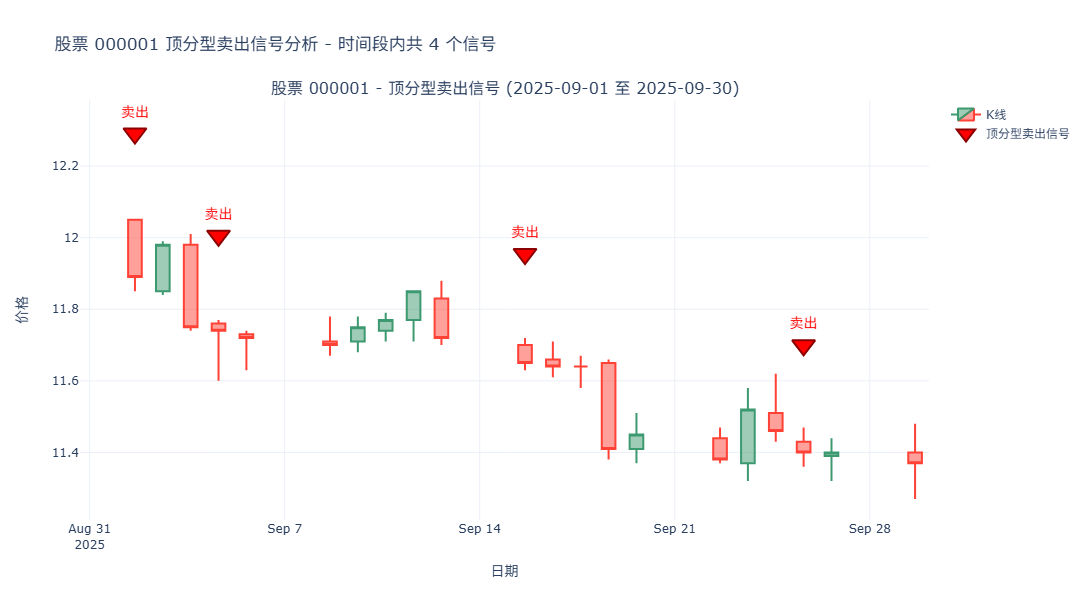

2025-10-15 18:11:40,412 - INFO - 获取股票 000001 数据，从 2025-07-01 00:00:00 到 2025-09-30 00:00:00
2025-10-15 18:11:40,624 - INFO - 过滤后数据量: 65 条


图表已保存为: 顶分型卖出信号_最近1个月.html

生成 最近3个月 的图表...


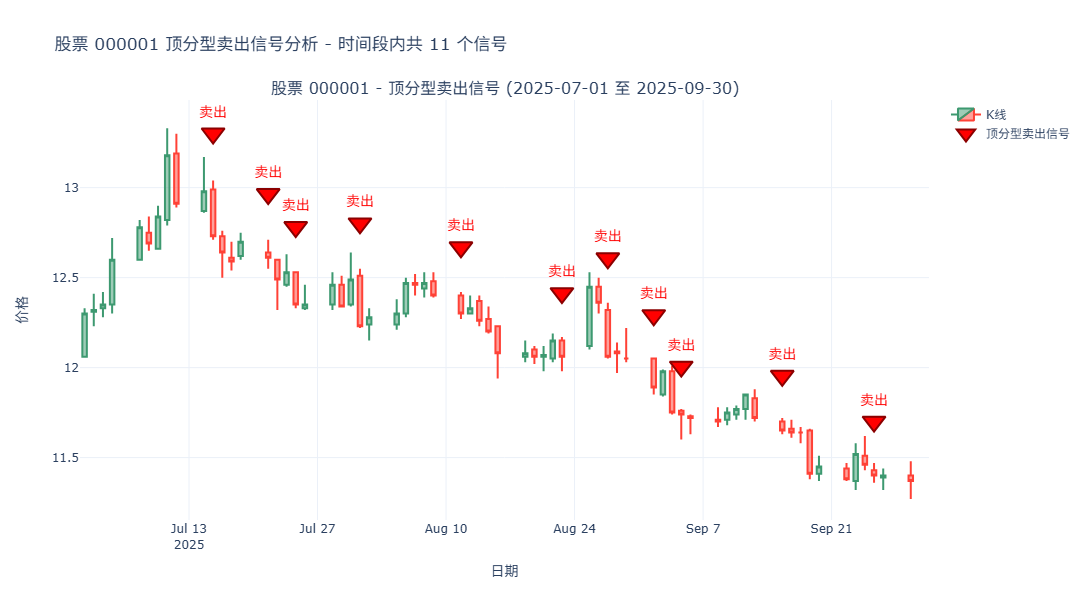

2025-10-15 18:11:40,759 - INFO - 获取股票 000001 数据，从 2025-04-01 00:00:00 到 2025-09-30 00:00:00


图表已保存为: 顶分型卖出信号_最近3个月.html

生成 最近6个月 的图表...


2025-10-15 18:11:40,970 - INFO - 过滤后数据量: 125 条


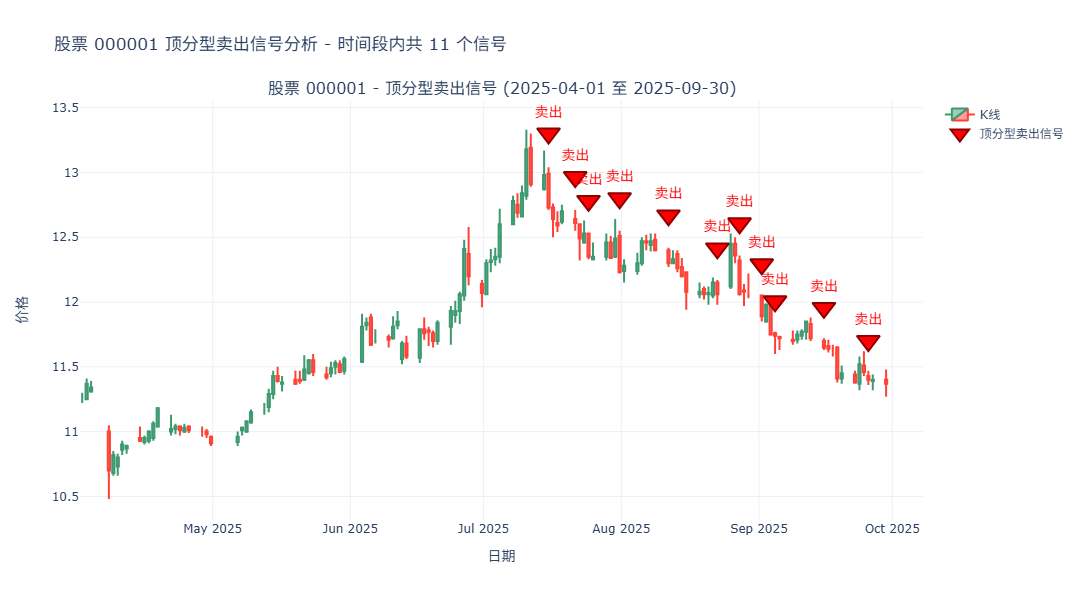

2025-10-15 18:11:41,124 - INFO - 获取股票 000001 数据，从 2025-07-01 00:00:00 到 2025-09-25 00:00:00


图表已保存为: 顶分型卖出信号_最近6个月.html

生成 所有信号 的图表...


2025-10-15 18:11:41,345 - INFO - 过滤后数据量: 62 条


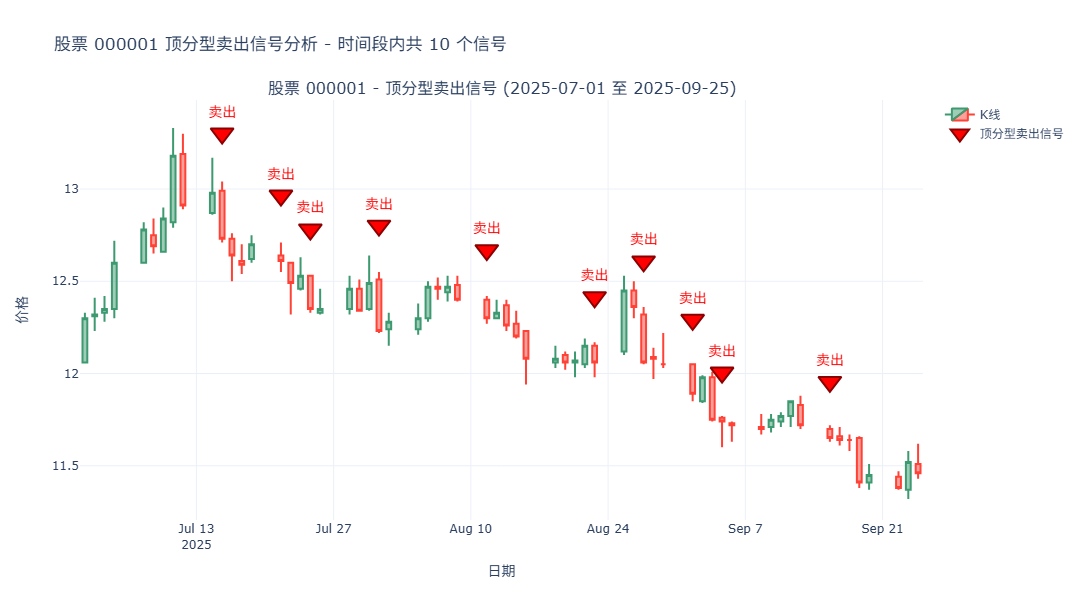

图表已保存为: 顶分型卖出信号_所有信号.html

所有图表生成完成！


In [43]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import logging

# 配置日志
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TopPatternVisualizer:
    def __init__(self, data_provider):
        """
        顶分型可视化器
        
        Args:
            data_provider: TDXDataProvider实例
        """
        self.signals = []
        self.data_provider = data_provider
    
    def parse_signals_from_log(self, log_text):
        """从日志文本中解析卖出信号"""
        lines = log_text.strip().split('\n')
        
        for line in lines:
            if '卖出信号' in line:
                try:
                    # 解析股票代码
                    stock_code = line.split('卖出信号: ')[1].split(',')[0].strip()
                    
                    # 解析价格
                    price_str = line.split('价格=')[1].split(',')[0].strip()
                    price = float(price_str)
                    
                    # 解析日期
                    date_str = line.split('日期=')[1].split(',')[0].strip()
                    signal_date = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
                    
                    # 解析A线高和A线低
                    a_high_str = line.split('A线高=')[1].split(',')[0].strip()
                    a_low_str = line.split('A线低=')[1].strip()
                    a_high = float(a_high_str)
                    a_low = float(a_low_str)
                    
                    self.signals.append({
                        'stock_code': stock_code,
                        'date': signal_date,
                        'price': price,
                        'a_high': a_high,
                        'a_low': a_low
                    })
                    
                except Exception as e:
                    print(f"解析信号失败: {line}, 错误: {e}")
    
    def get_stock_data_for_period(self, stock_code, start_date, end_date, count=800):
        """
        获取指定时间段的股票数据
        
        Args:
            stock_code: 股票代码
            start_date: 开始日期
            end_date: 结束日期
            count: 获取的K线数量
        """
        logger.info(f"获取股票 {stock_code} 数据，从 {start_date} 到 {end_date}")
        
        # 获取K线数据
        kline_data = self.data_provider.get_kline_data(stock_code, period='daily', count=count)
        
        if kline_data is None:
            logger.error("获取K线数据失败")
            return None
        
        # 过滤数据到指定时间段
        mask = (kline_data['datetime'] >= start_date) & (kline_data['datetime'] <= end_date)
        filtered_data = kline_data.loc[mask]
        
        logger.info(f"过滤后数据量: {len(filtered_data)} 条")
        return filtered_data
    
    def create_chart_with_signals(self, stock_code='600036', start_date=None, end_date=None, show_volume=True):
        """创建带有顶分型卖出信号的K线图，可指定时间段"""
        # 如果没有指定时间范围，使用默认范围（最近3个月）
        if end_date is None:
            end_date = datetime.now()
        if start_date is None:
            start_date = end_date - timedelta(days=90)  # 默认3个月
        
        # 获取股票数据
        stock_data = self.get_stock_data_for_period(stock_code, start_date, end_date)
        if stock_data is None or len(stock_data) == 0:
            logger.error(f"无法获取股票 {stock_code} 在指定时间段的数据")
            return None
        
        # 检查必要的列是否存在
        required_columns = ['datetime', 'open', 'high', 'low', 'close']
        missing_columns = [col for col in required_columns if col not in stock_data.columns]
        if missing_columns:
            logger.error(f"缺少必要的列: {missing_columns}")
            return None
        
        # 检查是否有成交量数据
        has_volume = 'volume' in stock_data.columns and show_volume
        
        # 创建图表 - 根据是否有成交量决定子图数量
        if has_volume:
            fig = make_subplots(
                rows=2, cols=1,
                shared_xaxes=True,
                vertical_spacing=0.1,
                subplot_titles=(
                    f'股票 {stock_code} - 顶分型卖出信号 ({start_date.strftime("%Y-%m-%d")} 至 {end_date.strftime("%Y-%m-%d")})', 
                    '成交量'
                ),
                row_heights=[0.7, 0.3]  # 正确的参数名是row_heights
            )
        else:
            fig = make_subplots(
                rows=1, cols=1,
                subplot_titles=(
                    f'股票 {stock_code} - 顶分型卖出信号 ({start_date.strftime("%Y-%m-%d")} 至 {end_date.strftime("%Y-%m-%d")})', 
                )
            )
        
        # 添加K线
        fig.add_trace(
            go.Candlestick(
                x=stock_data['datetime'],
                open=stock_data['open'],
                high=stock_data['high'],
                low=stock_data['low'],
                close=stock_data['close'],
                name='K线'
            ),
            row=1, col=1
        )
        
        # 添加卖出信号标记
        sell_signals = [s for s in self.signals if s['stock_code'] == stock_code]
        
        signal_dates = []
        signal_prices = []
        signal_texts = []
        signal_details = []
        
        for signal in sell_signals:
            # 检查信号是否在指定时间段内
            if not (start_date <= signal['date'] <= end_date):
                continue
                
            # 找到最接近信号日期的K线
            date_diff = abs(stock_data['datetime'] - signal['date'])
            if len(date_diff) == 0:
                continue
                
            closest_idx = date_diff.argmin()
            closest_date = stock_data.iloc[closest_idx]['datetime']
            closest_high = stock_data.iloc[closest_idx]['high']
            
            # 在K线上方显示标记
            marker_price = closest_high * 1.02
            
            signal_dates.append(closest_date)
            signal_prices.append(marker_price)
            
            # 创建信号文本
            text = f"卖出"
            signal_texts.append(text)
            
            # 创建详细信息（用于悬停显示）
            detail = (f"<b>顶分型卖出信号</b><br>"
                     f"日期: {signal['date'].strftime('%Y-%m-%d')}<br>"
                     f"信号价格: {signal['price']:.2f}<br>"
                     f"A线高: {signal['a_high']:.2f}<br>"
                     f"A线低: {signal['a_low']:.2f}<br>"
                     f"当前K线高价: {closest_high:.2f}")
            signal_details.append(detail)
        
        # 添加卖出信号点
        if signal_dates:
            fig.add_trace(
                go.Scatter(
                    x=signal_dates,
                    y=signal_prices,
                    mode='markers+text',
                    marker=dict(
                        symbol='triangle-down',
                        size=20,
                        color='red',
                        line=dict(width=2, color='darkred')
                    ),
                    text=signal_texts,
                    textposition="top center",
                    textfont=dict(color='red', size=14),
                    name='顶分型卖出信号',
                    hovertemplate='%{customdata}<extra></extra>',
                    customdata=signal_details,
                ),
                row=1, col=1
            )
        
        # 添加成交量（如果有）
        if has_volume:
            colors = ['red' if close >= open else 'green' 
                     for close, open in zip(stock_data['close'], stock_data['open'])]
            
            fig.add_trace(
                go.Bar(
                    x=stock_data['datetime'],
                    y=stock_data['volume'],
                    marker_color=colors,
                    name='成交量',
                    opacity=0.7
                ),
                row=2, col=1
            )
        
        # 更新布局
        fig.update_layout(
            title=f'股票 {stock_code} 顶分型卖出信号分析 - 时间段内共 {len(signal_dates)} 个信号',
            xaxis_title='日期',
            yaxis_title='价格',
            xaxis_rangeslider_visible=False,
            height=800 if has_volume else 600,
            showlegend=True,
            template='plotly_white',
            font=dict(size=12)
        )
        
        # 更新y轴标题
        fig.update_yaxes(title_text="价格", row=1, col=1)
        if has_volume:
            fig.update_yaxes(title_text="成交量", row=2, col=1)
        
        return fig

# 使用示例 - 提供多个时间段选项
if __name__ == "__main__":
    # 创建数据提供器
 
    data_provider = TDXDataProvider()
    
    # 创建可视化器
    visualizer = TopPatternVisualizer(data_provider)
    
    # 你的日志文本
    log_text = """
2025-10-15 18:09:47,023 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-07-15 15:00:00, A线高=13.33, A线低=12.79
2025-10-15 18:09:47,739 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-07-21 15:00:00, A线高=12.75, A线低=12.60
2025-10-15 18:09:48,312 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-07-24 15:00:00, A线高=12.63, A线低=12.45
2025-10-15 18:09:49,204 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-07-31 15:00:00, A线高=12.64, A线低=12.34
2025-10-15 18:09:50,504 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-08-11 15:00:00, A线高=12.53, A线低=12.39
2025-10-15 18:09:52,147 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-08-22 15:00:00, A线高=12.19, A线低=12.03
2025-10-15 18:09:52,682 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-08-27 15:00:00, A线高=12.53, A线低=12.10
2025-10-15 18:09:53,230 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-09-01 15:00:00, A线高=12.22, A线低=12.03
2025-10-15 18:09:53,771 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-09-04 15:00:00, A线高=12.01, A线低=11.74
2025-10-15 18:09:55,323 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-09-15 15:00:00, A线高=11.88, A线低=11.70
2025-10-15 18:09:56,834 - INFO - 卖出信号: 000001, 价格=11.40, 日期=2025-09-25 15:00:00, A线高=11.62, A线低=11.43
"""
    
    # 解析信号
    visualizer.parse_signals_from_log(log_text)
    
    print(f"解析到 {len(visualizer.signals)} 个卖出信号")
    
    # 提供多个时间段选项
    time_periods = [
        ("最近1个月", datetime(2025, 9, 1), datetime(2025, 9, 30)),
        ("最近3个月", datetime(2025, 7, 1), datetime(2025, 9, 30)),
        ("最近6个月", datetime(2025, 4, 1), datetime(2025, 9, 30)),
        ("所有信号", datetime(2025, 7, 1), datetime(2025, 9, 25)),
    ]
    
    for period_name, start_date, end_date in time_periods:
        print(f"\n生成 {period_name} 的图表...")
        fig = visualizer.create_chart_with_signals('000001', start_date, end_date)
        
        if fig:
            # 显示图表
            fig.show()
            
            # 保存为HTML文件
            filename = f"顶分型卖出信号_{period_name}.html"
            fig.write_html(filename)
            print(f"图表已保存为: {filename}")
        else:
            print(f"{period_name} 图表生成失败")
    
    print("\n所有图表生成完成！")